In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import KFold
from CRPS import CRPS
from CRPS_function import CRPS_function

In [2]:
# set seed                
np.random.seed(142)    # for reproducibility and comparability

# set up training, calibration and validation set. Training set consists of proper training set to train underlying ML model and calibration set
# set size of training and validation set 
n = 1000 # size of the training set
m = int(0.8 * n) # size of the proper training set

# compute size of the calibration set
n_cal = n - m 

n_test = 100
sd_noise = 1

n_delta = 1000 # discretization for y values in the interval of y_hat +/- 3 * delta
w = 2 # the weights

In [3]:
# generate training set 

# generate object of the training set, note x_train and y_train refer to what is called proper training set
x_train = w * np.random.random(m) - 1 # training attributes, generated from uniform distribution
x_cal = w * np.random.random(n_cal) - 1 # calibration attributes, generated from uniform distribution
x_test = w * np.random.random(n_test) - 1 # test attributes, generated from uniform distribution

# initialize arrays to store labels of the training, validation and test set                           
y_train = np.empty(m)             # initializing zero valued array of training labels
y_cal = np.empty(n_cal)             # initializing zero valued array of calibration labels
y_test = np.empty(n_test)

# compute labels for proper training set, calibration set and test set              
y_train = w * x_train + np.random.randn(m) * sd_noise
y_cal = w * x_cal + np.random.randn(n_cal) * sd_noise
y_test = w * x_test + np.random.randn(n_test) * sd_noise

# stack training objects and labels into matrices X & y 
x_train_cal = np.reshape(np.hstack((x_train, x_cal)), (n,1))
y_train_cal = np.reshape(np.hstack((y_train, y_cal)), (n,1))

xy_train_cal = np.hstack((x_train_cal, y_train_cal)) 

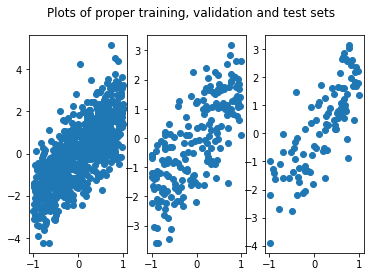

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Plots of proper training, validation and test sets')


# use plot to check synthetic data set has been generated correctly           
ax1.scatter(x_train, y_train)                                                 
ax2.scatter(x_cal, y_cal)                                                 
ax3.scatter(x_test, y_test)      

In [5]:
# Part I. The first part of the ICPD algorithm is easy - train your favourite ML algorithm the proper training set. 
# perform linear regression
# Note the difference in argument order
model = sm.OLS(y_train, x_train).fit()
predictions = model.predict(x_train) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.553
Model:                            OLS   Adj. R-squared (uncentered):              0.552
Method:                 Least Squares   F-statistic:                              988.2
Date:                Wed, 24 Mar 2021   Prob (F-statistic):                   8.00e-142
Time:                        10:46:23   Log-Likelihood:                         -1152.9
No. Observations:                 800   AIC:                                      2308.
Df Residuals:                     799   BIC:                                      2312.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0024      0.064     31.436      0.000       1.877       2.127
==============================================================================
Omnibus:                        4.066   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.131   Jarque-Bera (JB):                3.976
Skew:                           0.136   Prob(JB):                        0.137
Kurtosis:                       3.214   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
# regression coefficient
model.params

array([2.00244389])

No handles with labels found to put in legend.


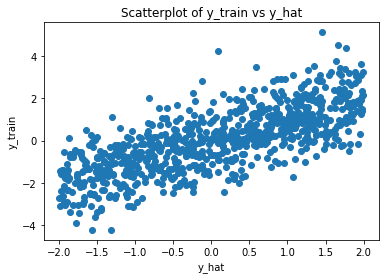

In [7]:
# plot training set vs predictions labels on the same plot
plt.scatter(predictions, y_train)
plt.xlabel('y_hat')
plt.ylabel('y_train')
plt.title('Scatterplot of y_train vs y_hat')
plt.legend(loc='upper left', frameon = False)
plt.show()                                              

In [8]:
## Split (inductive) Conformal Predictive Distributions
y_hat_cal =  model.predict(x_cal) # make predictions on the calibration set
alpha_cal = y_cal - y_hat_cal # compute alphas (conformity scores) on the calibrations set 

In [9]:
# Part II. In second part of the ICPD algorithm fitted ML model is used to make predictions on the calibration set.
## Split (inductive) Conformal Predictive Distributions
y_hat_cal =  model.predict(x_cal) # make predictions on the calibration set
alpha_cal = y_cal - y_hat_cal # compute alphas (conformity scores) on the calibrations set 

In [10]:
# Perform various initializations to store results of probabilistic predictions

# initialize vector for storing CRPS for the test set, CRPS is computed using CRPS.py and CRPS_function.py
CRPS_min = np.empty(len(x_test))
CRPS_max = np.empty(len(x_test))
CRPS_icpd = np.empty(len(x_test))

# initialize array to store Q (the output of split conformal trancducer as per formula (1) in the paper)
# Q_min corresponds to the value of tau = 0, Q_max corresponds to the value of tau = 1
Q_min = np.empty((n_test,n_delta))
Q_min[:] = np.NaN
Q_max = np.empty((n_test,n_delta))
Q_max[:] = np.NaN

# initialize array for storing alphas for the test set 
alpha_y = np.empty((n_test,n_delta))
alpha_y[:] = np.NaN

# initialize array to store predictions of the underlying algorithm on the test set
y_hat = np.empty(n_test)
y_hat[:] = np.NaN

In [11]:
# Part III. Compute point and probabilistic predictions on the test set

# compute y_hat (predictions of the underlying algorithm) on the test and calibration sets
y_hat = model.predict(x_test) # make predictions by the model for the test set
delta = 3 * np.std(y_hat) # +/- delta around y_hat (predicted value of y_test, length of range around y_hat is 3 * delta

# create a grid for probabilistic predictions for the test set. Interval between min and max predictions is extended at both ends by 3 standard deviations and discretized
y_grid = np.linspace(y_hat.min() - delta, y_hat.max() + delta, n_delta)

In [12]:
# compute Q & CRPS for the test set
for l in range(len(x_test)):
    # create the grid around y_hat
    alpha_y[l] = y_grid - y_hat[l]
    
    for i in range(len(y_grid)):
        Q_min[l,i] = 1/ (n_cal + 1) * np.sum(alpha_cal < alpha_y[l,i])
        Q_max[l,i] = 1/ (n_cal + 1) * (np.sum(alpha_cal < alpha_y[l,i]) + np.sum(alpha_cal == alpha_y[l,i])) + 1/(n_cal + 1)  

    CRPS_min[l] = CRPS(y_grid, Q_min[l], y_test[l], n)
    CRPS_max[l] = CRPS(y_grid, Q_max[l], y_test[l], n)
    CRPS_icpd[l]  = (CRPS_min[l] + CRPS_max[l]) / 2   

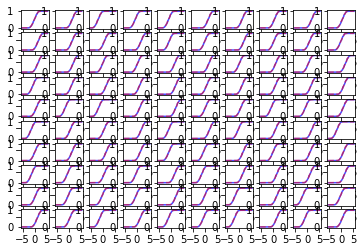

In [13]:
### visualize probabilistic predictions - plot Q for the test set

fig, ax = plt.subplots(10,10)
for l in range(len(x_test)):
    plt.subplot(10,10,l+1)
    q_min = Q_min[l]
    q_max = Q_max[l]
    plt.plot(y_grid, q_min, '-b', label='q_min', alpha=0.7)                                                 
    plt.plot(y_grid, q_max, '--r', label='q_max', alpha=0.5)
    #plt.xlabel('y-grid')
    #plt.ylabel('Q')
    #plt.title('Plot of Q_min and Q-max')

plt.show()
###

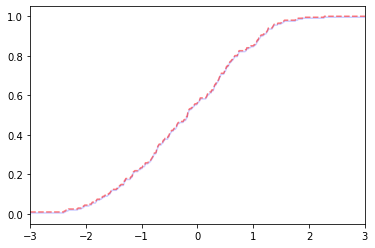

In [14]:
# Visualize probabilistic predictions for specific points in test set
#change index here to obtain Q-plots for different objects in the test set
q_min = Q_min[0]
q_max = Q_max[0]

plt.plot(y_grid, q_min, '-b', label='q_min', alpha=0.2)                                                 
plt.plot(y_grid, q_max, '--r', label='q_max', alpha=0.5)
#plt.xlabel('y-grid')
#plt.ylabel('Q')
#plt.title('Plot of Q_min and Q-max')
plt.xlim(-3,3)
plt.show()


Text(0.5, 1.0, 'CRPS for the test set, linear regression')

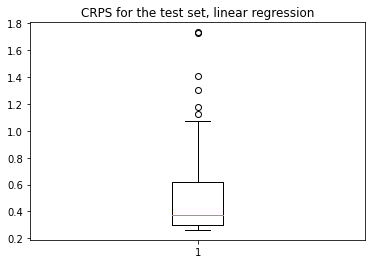

In [15]:
### Boxplot of CRPS distribution
plt.boxplot(CRPS_icpd)
plt.title('CRPS for the test set, linear regression')

In [16]:
print('Number of objects in the test set is {}:'.format(len(x_test)))
print('Sum of all CRPSs on the testing set is {}:'.format(np.sum(CRPS_icpd)))
print('Mean CRPS on the testing set is {}:'.format(np.mean(CRPS_icpd)))
print('Median CRPS on the testing set is {}:'.format(np.median(CRPS_icpd)))
print('Maximum CRPS on the testing set is {}:'.format(CRPS_icpd.max())) 
print('Which point in the test set results in maximum CRPS: {}'.format(np.argmax(CRPS_icpd))) 

Number of objects in the test set is 100:
Sum of all CRPSs on the testing set is 51.754462788739595:
Mean CRPS on the testing set is 0.517544627887396:
Median CRPS on the testing set is 0.37183858837607486:
Maximum CRPS on the testing set is 1.7332063098280561:
Which point in the test set results in maximum CRPS: 14


In [17]:
### We now implement Cross Conformal Predictive Distributions
x_train_cal =  np.vstack((np.reshape(x_train, (m,1)), np.reshape(x_cal, (n_cal,1)))) # objects from proper training-calibration set
y_train_cal = np.vstack((np.reshape(y_train, (m,1)), np.reshape(y_cal, (n_cal,1)))) # labels proper training-calibration set

In [18]:
# concatenate training-calibration set objects and labels
xy_train_cal = np.concatenate((x_train_cal, y_train_cal), axis = 1)  
K = 5 # number of folds
# vector of fold sizes
S = np.empty(K)
S[:] = np.NaN

In [19]:
# 3-D arrays to store Q
Q_folds = np.empty((n_test,n_delta,K))
Q_folds[:] = np.NaN

In [20]:
# p-values for cross-conformal prediction distributuion (CCPD)
p_folds = np.zeros((n_test,n_delta))

In [21]:
kf = KFold(n_splits=K)

In [22]:
# similar to ICPD, create a grid
delta = 3 * np.std(y_hat) # +/- delta around y_hat (predicted value of y_test, length of range around y_hat is 2 * delta
y_grid = np.linspace(y_hat.min() - delta, y_hat.max() + delta, n_delta) # create the grid around y_hat

In [23]:
# initialize array for alphas 
alpha_y_fold = np.empty((n_test,n_delta))

In [24]:
# compute Q & CRPS for the test set but now for cross conformal version - this is essentially more involved version compared to Part IV above

for l in range(len(x_test)):
    k = 0
    alpha_y_fold[:] = np.NaN 
    for train_ind, cal_ind in kf.split(xy_train_cal):
        train_data = xy_train_cal[train_ind]
        cal_data = xy_train_cal[cal_ind]
        x_train = train_data[:,:-1]
        y_train = train_data[:,-1]
        x_cal = cal_data[:,:-1]
        y_cal = cal_data[:,-1]
        S[k] = len(x_cal)
        # train the model on the k-th training set
        model = sm.OLS(y_train, x_train).fit()
        y_hat_cal =  model.predict(x_cal) # predictions on the calibration set
        y_hat = model.predict(x_test) # make predictions on the test set
        
        alpha_y_fold[l] = y_grid - y_hat[l] # compute alpha for test point
        alpha_cal_fold = y_cal - y_hat_cal

        ### Compute Q 
        for i in range(len(y_grid)):
            Q_folds[l,i,k] = 1/ (len(x_cal) + 1) * np.sum(alpha_cal_fold < alpha_y_fold[l,i]) # formula (8)
        k = k + 1

# compute p
for l in range(len(x_test)):
    for i in range(len(y_grid)):
        for k in range(K):
            p_folds[l,i] = p_folds[l,i] + (S[k] + 1) / (n +1) * Q_folds[l,i,k] # formula (9) 

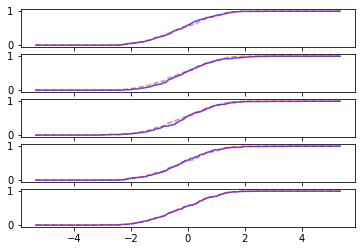

In [25]:
# plot Q for K folds
fig, ax = plt.subplots(K,1)
for k in range(K):
    plt.subplot(K, 1, k+1)
    q_min = Q_folds[0,:,k]
    plt.plot(y_grid, q_min, '-b', label='q_min', alpha=0.7)                                                 
    plt.plot(y_grid, q_max, '--r', label='q_max', alpha=0.5)
    #plt.xlabel('y-grid')
    #plt.ylabel('Q')
    #plt.title('Plot of Q_min and Q-max for different folds')
plt.show()

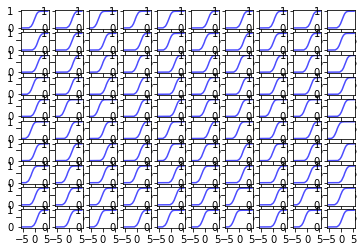

In [26]:
# plot p in 10 x 10 subplots
fig, ax = plt.subplots(10,10)
for l in range(len(x_test)):
    plt.subplot(10,10,l+1)
    p = p_folds[l]
    plt.plot(y_grid, p, '-b', label='q_min', alpha=0.7)                                                 
    #plt.xlabel('y-grid')
    #plt.ylabel('Q')
    #plt.title('Plot of Q_min and Q-max')

plt.show()

Text(0.5, 1.0, 'CRPS for the test set (by each fold, fixed K), linear regression')

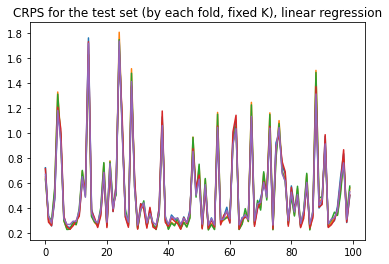

In [27]:
# compute CRPS

CRPS_fold = np.empty((n_test,K))
CRPS_fold[:] = np.NaN

for l in range(len(x_test)):
    for k in range(K):
        CRPS_fold[l,k] = CRPS(y_grid, Q_folds[l,:,k], y_test[l], n)
        
# plot CRPS
plt.plot(CRPS_fold)
plt.title('CRPS for the test set (by each fold, fixed K), linear regression')

K = 2
K = 3
K = 4
K = 5
K = 6
K = 7
K = 8
K = 9
K = 10
K = 20
K = 30
K = 40
K = 60
K = 80
K = 100


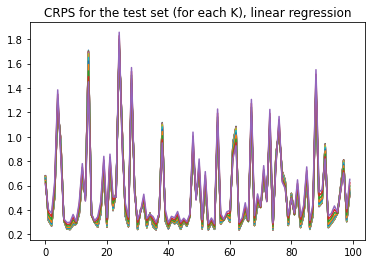

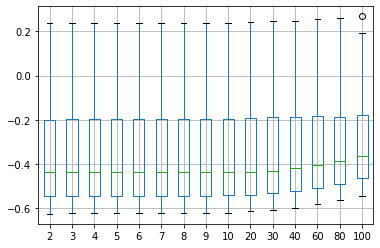

0.010000000000000009
0.050000000000000044
0.09999999999999998
0.19999999999999996
0.30000000000000004
0.4
0.5
0.6
0.7
0.8
0.9
0.95
0.99


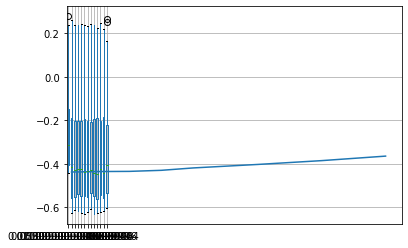

9

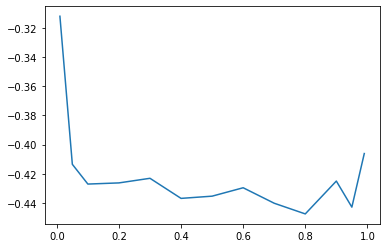

In [28]:
# =============================================================================
# plot Q for K folds

# compute CRPS over different number of folds
from CCPD import CCPD_function

K_range = [2,3,4,5,6,7,8,9,10,20,30,40,60,80,100]

fold_K = len(K_range)

L = 5# number of simulations

p_folds_test = np.empty((n_test,n_delta,fold_K,L))
p_folds_test[:] = np.NaN

CRPS_fold_test = np.empty((n_test,fold_K,L))
CRPS_fold_test[:] = np.NaN

for k in range(fold_K):
    for l in range(L):
        (_, p_folds_test[:,:,k,l]) = CCPD_function \
        (x_train_cal, y_train_cal, x_test, y_test, y_grid, K_range[k], n_delta)
        for i_test in range(len(x_test)):
            CRPS_fold_test[i_test,k,l] = CRPS_function(y_grid, p_folds_test[i_test,:,k,l], y_test[i_test])
    print('K =', K_range[k])

CRPS_fold_test = np.mean(CRPS_fold_test, axis = 2)

# plot CRPS
plt.plot(CRPS_fold_test)
plt.title('CRPS for the test set (for each K), linear regression')
plt.show()

# log - for the plots
CRPS_fold_log10_pd = pd.DataFrame(np.log10(CRPS_fold_test))
CRPS_fold_log10_pd.columns = K_range
CRPS_fold_log10_pd.boxplot()
#plt.title('Mean CRPS for the test set')
#plt.xlabel('Number of folds')
#plt.ylabel('CRPS')
plt.show()

plt.plot(K_range, np.median(CRPS_fold_log10_pd, axis = 0))

np.median(CRPS_fold_log10_pd, axis = 0).min()
np.argmin(np.median(CRPS_fold_log10_pd, axis = 0))

# non-log - for the numbers
CRPS_fold_pd = pd.DataFrame(CRPS_fold_test)
CRPS_fold_pd.columns = K_range

np.median(CRPS_fold_pd, axis = 0).min()
np.argmin(np.median(CRPS_fold_pd, axis = 0))

##########################################################
### experiments with changing K - size plit in training vs 
from SCPD import SCPD_function

# compute y_hat (predictions of the underlyin algorithm) on the test and calibration sets
model = sm.OLS(y_train_cal, x_train_cal).fit()
y_hat = model.predict(x_test) # make predictions by the model for the test set
delta = 3 * np.std(y_hat) # +/- delta around y_hat (predicted value of y_test, length of range around y_hat is 2 * delta
y_grid = np.linspace(y_hat.min() - delta, y_hat.max() + delta, n_delta)

# ratio of length proper training set to length of training set 
train_cal_ratio = np.array([0.99, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01])
train_cal_ratio = 1 - train_cal_ratio

K_range = 1 / train_cal_ratio
fold_K = len(K_range)

L = 5# number of simulations

CRPS_icpd_fold_test = np.empty((n_test,fold_K,L))
CRPS_icpd_fold_test[:] = np.NaN

for k in range(fold_K):
    for l in range(L):
        ind = np.random.permutation(len(x_train_cal))
        cal_ind = ind[:int(len(ind) * train_cal_ratio[k])]
        train_ind = ind[int(len(ind) * train_cal_ratio[k]):]

        train_data = xy_train_cal[train_ind]
        cal_data = xy_train_cal[cal_ind]
        x_train = train_data[:,:-1]
        y_train = train_data[:,-1]
        x_cal = cal_data[:,:-1]
        y_cal = cal_data[:,-1]
        (_, CRPS_icpd_fold_test[:,k,l]) = SCPD_function(x_train,\
        x_cal, y_train, y_cal, x_test, y_test, y_grid, K_range[k], n_delta, shuffle_ind = True)
    print(train_cal_ratio[k])

CRPS_icpd_fold_test = np.mean(CRPS_icpd_fold_test, axis = 2)

CRPS_icpd_fold_log10_pd = pd.DataFrame(np.log10(CRPS_icpd_fold_test))
CRPS_icpd_fold_log10_pd.columns =  train_cal_ratio
CRPS_icpd_fold_log10_pd.boxplot()
#plt.title('Mean CRPS for the test set')
#plt.xlabel('Number of folds')
#plt.ylabel('CRPS')
plt.show()

CRPS_median_log10 = np.median(CRPS_icpd_fold_log10_pd, axis = 0)
plt.plot(train_cal_ratio, np.median(CRPS_icpd_fold_log10_pd, axis = 0)) 

CRPS_median_log10.min()
np.argmin(CRPS_median_log10)

CRPS_icpd_fold_pd = pd.DataFrame(CRPS_icpd_fold_test)
CRPS_icpd_fold_pd.columns =  train_cal_ratio
CRPS_median = np.median(CRPS_icpd_fold_pd, axis = 0)
CRPS_median.min()
np.argmin(CRPS_median)

In [29]:
print('Hello')

Hello
